In [43]:
'ADC to FFT empty seat new approach'


'ADC to FFT empty seat new approach'

# Loading the Data

In [90]:
import gc
gc.collect()

2527

In [92]:
%reset -f

In [94]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [100]:
# Set directory containing CSV files
data_dir = r"D:\AIS & ML\realtime testing\testempty"

# Load all CSV files
csv_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]
dfs = [pd.read_csv(file, header=None) for file in csv_files]


In [104]:
# Combine all CSV data
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,16390,16391,16392,16393,16394,16395,16396,16397,16398,16399
0,64,32768,1,1,512,0,1953125,12,0.0,0,...,40,36,38,32,29,25,19,21,18,16
1,64,32768,1,1,512,0,1953125,12,0.0,0,...,-15,-20,-25,-29,-20,-22,-22,-26,-24,-22
2,64,32768,1,1,512,0,1953125,12,0.0,0,...,13,18,13,13,19,20,24,25,26,24
3,64,32768,1,1,512,0,1953125,12,0.0,0,...,-38,-37,-39,-44,-41,-39,-36,-35,-33,-31
4,64,32768,1,1,512,0,1953125,12,0.0,0,...,40,42,39,37,41,42,44,43,39,38
5,64,32768,1,1,512,0,1953125,12,0.0,0,...,3,0,-1,0,0,-1,2,5,3,4
6,64,32768,1,1,512,0,1953125,12,0.0,0,...,32,30,28,26,25,23,22,23,20,18
7,64,32768,1,1,512,0,1953125,12,0.0,0,...,32,31,26,22,20,19,19,16,18,16
8,64,32768,1,1,512,0,1953125,12,0.0,0,...,9,11,8,8,13,16,23,22,21,20
9,64,32768,1,1,512,0,1953125,12,0.0,0,...,28,23,19,20,20,19,17,17,15,15


In [106]:
combined_df.shape

(12, 16400)

In [116]:
adc_data = combined_df.iloc[:, 16:].values  # Extract ADC values (skip metadata columns)
adc_data
#print(f"Loaded data shape: {adc_data.shape}")  # Shape should be (num_samples, num_features)


array([[ 12,   7,   1, ...,  21,  18,  16],
       [-23, -19, -16, ..., -26, -24, -22],
       [ 23,  25,  28, ...,  25,  26,  24],
       ...,
       [ 12,   8,   5, ...,  17,  15,  15],
       [ 11,  13,   7, ...,  15,  10,  10],
       [ 16,  13,  11, ...,  18,  11,  11]], shape=(12, 16384))

In [118]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(signal, cutoff=30e3, fs=1e6, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

filtered_data = np.array([butter_lowpass_filter(row) for row in adc_data])
filtered_data

array([[  4.18165255,   2.92333227,   2.46234692, ...,  25.51947711,
         24.1619642 ,  22.9163834 ],
       [ -8.78322541,  11.75890026,  31.59638371, ..., -25.53606062,
        -26.50339304, -27.28200936],
       [ 36.29910778,  40.5327981 ,  43.80592089, ...,  19.65088827,
         20.25062548,  20.80394935],
       ...,
       [  5.1184172 ,   5.42695712,   6.47246312, ...,  20.1388524 ,
         19.68339024,  19.24700762],
       [ -0.4754398 ,  -3.03867058,  -4.67060186, ...,  16.90514899,
         16.21702075,  15.5664942 ],
       [ 11.92821618,  15.92179821,  20.52764329, ...,  18.66224504,
         17.56762421,  16.56304003]], shape=(12, 16384))

In [120]:
def calculate_snr(signal, noise):
    power_signal = np.mean(signal ** 2)
    power_noise = np.mean(noise ** 2)
    return 10 * np.log10(power_signal / power_noise)

snr_after = calculate_snr(filtered_data, adc_data - filtered_data)
print(f"SNR After Fixing: {snr_after:.2f} dB")

SNR After Fixing: 20.60 dB


In [122]:
# Select from the 17th column to the end
adc_data_selected_columns = filtered_data.mean(axis=1)  # Python uses 0-based indexing
adc_data_selected_columns

array([ 3.7109258 ,  8.76114682, 20.48254845,  0.86515841, 20.37788742,
       12.29584111, 11.39051199, 11.45015366, 11.1327239 , 11.64897424,
       13.67702316, 24.58906486])

# ADC to FFT Conversion

In [125]:
# Convert the pandas Series to a numpy array
adc_array = adc_data_selected_columns 

# Choose a window function - Hanning window in this case
window = np.hanning(len(adc_array))

# Apply the window function to your data
windowed_adc_data = adc_array * window

# Perform FFT on the windowed data
fft_result = np.fft.fft(windowed_adc_data)

# Frequency bins (assuming you know the sampling rate)
sampling_rate = 1953125  # Example: 1000 Hz, replace with your actual sampling rate
min_freq = 35000  # 35 kHz
max_freq = 45000  # 45 kHz

n = len(adc_array)
freq = np.fft.fftfreq(n, d=1/sampling_rate)
# Calculate the magnitude and phase of the FFT result
magnitude = np.abs(fft_result)
phase = np.angle(fft_result)

# Create a DataFrame
fft_df = pd.DataFrame({
    'Frequency': freq,
    'FFT Magnitude': magnitude,
    'Phase': phase
})

fft_df.head()  # Display the first few rows of the DataFrame

,Frequency,FFT Magnitude,Phase
0,0.000000,67.567581,0.000000
1,162760.416667,39.172778,-2.828548
2,325520.833333,7.234232,1.109069
3,488281.250000,7.940564,-0.891679
4,651041.666667,11.650819,-2.861100


In [127]:
# Add a new column to the fft_magnitude DataFrame for the binary label
# Set the value to 1 for presence of an infant with a carriage
fft_df['Object_Presence'] =  # 1 for presence, 0 for absence (if you have such data)

# Display the first few rows to verify the new column
fft_df.head()

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,67.567581,0.000000,0
1,162760.416667,39.172778,-2.828548,0
2,325520.833333,7.234232,1.109069,0
3,488281.250000,7.940564,-0.891679,0
4,651041.666667,11.650819,-2.861100,0


In [129]:
len(fft_df)

12

In [131]:
fft_df

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,67.567581,0.000000e+00,0
1,162760.416667,39.172778,-2.828548e+00,0
2,325520.833333,7.234232,1.109069e+00,0
3,488281.250000,7.940564,-8.916786e-01,0
4,651041.666667,11.650819,-2.861100e+00,0
5,813802.083333,14.666073,1.652571e+00,0
6,-976562.500000,15.336658,-2.895606e-17,0
7,-813802.083333,14.666073,-1.652571e+00,0
8,-651041.666667,11.650819,2.861100e+00,0
9,-488281.250000,7.940564,8.916786e-01,0


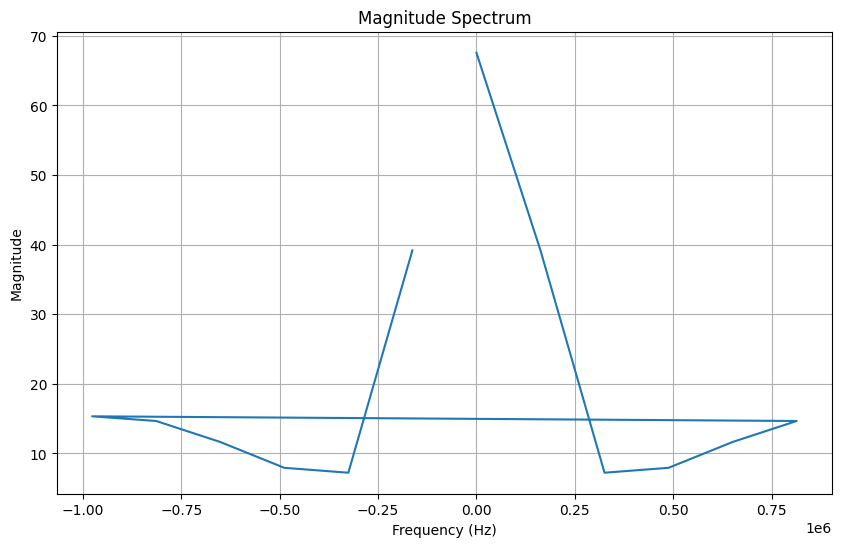

In [132]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(fft_df['Frequency'], fft_df['FFT Magnitude'])  # Plot positive frequency vs magnitude
plt.title('Magnitude Spectrum')  # Title of the plot
plt.xlabel('Frequency (Hz)')  # Label for the x-axis
plt.ylabel('Magnitude')  # Label for the y-axis
plt.grid(True)  # Show grid for better readability
plt.show()  # Display the plot

# Saving to numpy array

In [136]:
numpy_array = fft_df.to_numpy()
# Save the array to a file
np.save('realtime_test_Emptyseat_npy_array_Lowpassfiltered_label.npy', numpy_array)

In [39]:
import gc
gc.collect()

16731

In [41]:
%reset -f